In [12]:
import os
import random
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
import seaborn as sns

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB2, EfficientNetB0, ResNet50, DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [20]:
dataset path
DATASET_DIR = '/kaggle/input/rice-disease-dataset/Rice_Leaf_AUG'
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42
EPOCHS = 50

In [21]:
raw_datagen = ImageDataGenerator(rescale=1./255)
all_data_gen = raw_datagen.flow_from_directory(
    DATASET_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=SEED
)

Found 3829 images belonging to 6 classes.


In [22]:
filenames = all_data_gen.filepaths
classes = all_data_gen.classes
class_labels = list(all_data_gen.class_indices.keys())

# storing data
data = pd.DataFrame({
    'filename': filenames,
    'class': [class_labels[k] for k in classes]
})


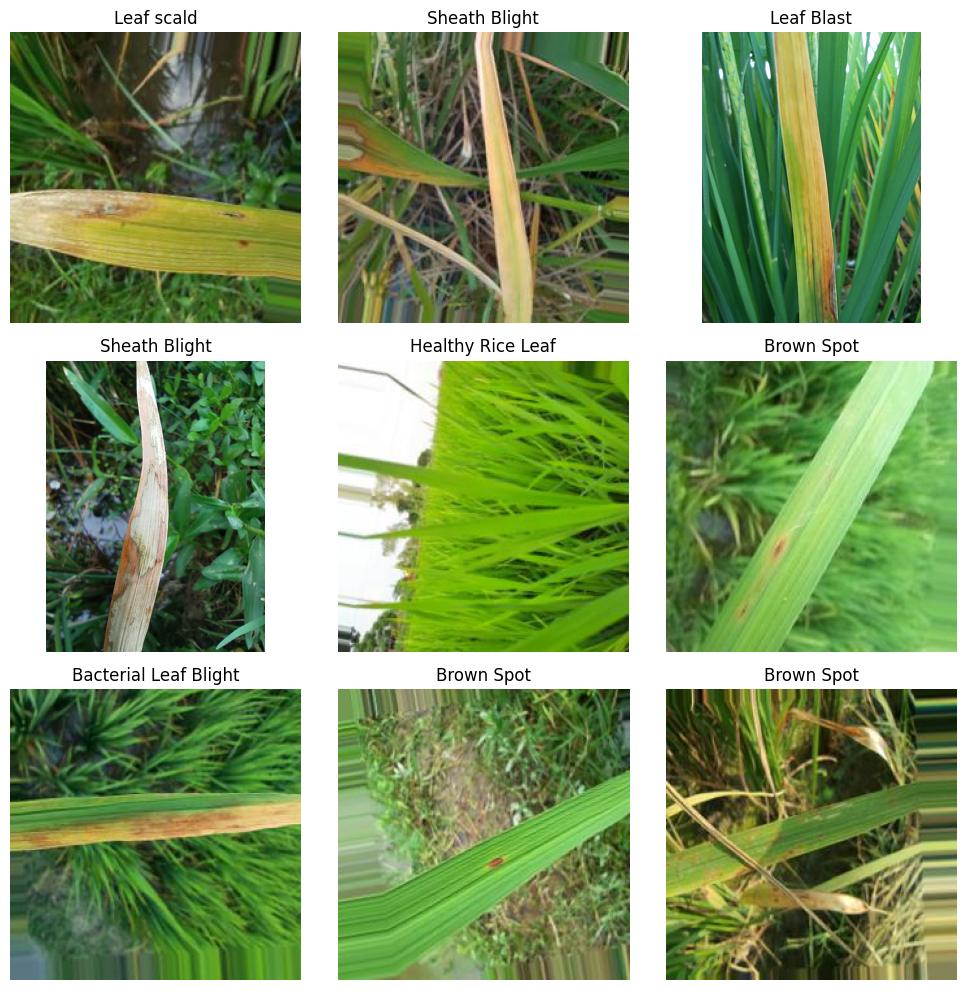

In [23]:
# Visualizing dataset
sample_df = data.sample(9, random_state=SEED).reset_index(drop=True)
plt.figure(figsize=(10, 10))
for i in range(9):
    img = cv2.imread(sample_df['filename'][i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.title(sample_df['class'][i])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [24]:
# 70:15:15
train_data, temp_data = train_test_split(data, test_size=0.3, stratify=data['class'], random_state=SEED)
val_data, test_data = train_test_split(temp_data, test_size=0.5, stratify=temp_data['class'], random_state=SEED)

In [25]:
#augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

In [26]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='filename', y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)
val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col='filename', y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)
test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_data,
    x_col='filename', y_col='class',
    target_size=IMG_SIZE,
    batch_size=1,
    class_mode='categorical',
    shuffle=False
)

Found 2680 validated image filenames belonging to 6 classes.
Found 574 validated image filenames belonging to 6 classes.
Found 575 validated image filenames belonging to 6 classes.


In [27]:
#traihing function
def build_model(base_model_class, input_shape, num_classes):
    base_model = base_model_class(weights='imagenet', include_top=False, input_shape=input_shape)
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.4)(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.2)(x)
    predictions = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

In [28]:
models_to_test = {
    'EfficientNetB2': EfficientNetB2,
    'EfficientNetB0': EfficientNetB0,
    'ResNet50': ResNet50,
    'DenseNet121': DenseNet121
}


In [29]:
#training
results = {}

for name, base_class in models_to_test.items():
    print(f"\nTraining {name}...")
    model = build_model(base_class, input_shape=(224, 224, 3), num_classes=len(class_labels))
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=EPOCHS,
        callbacks=[early_stop],
        verbose=1
    )

    test_loss, test_acc = model.evaluate(test_generator)
    print(f"{name} Test Accuracy: {test_acc:.4f}")

    y_true = test_generator.classes
    y_pred_probs = model.predict(test_generator)
    y_pred = np.argmax(y_pred_probs, axis=1)

    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)
    auc_score = roc_auc_score(to_categorical(y_true), y_pred_probs, multi_class='ovr')

    results[name] = {
        'history': history,
        'test_acc': test_acc,
        'conf_matrix': cm,
        'class_report': cr,
        'auc_score': auc_score
    }



Training EfficientNetB2...


I0000 00:00:1750777014.753576      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750777014.754319      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50


I0000 00:00:1750777097.562746     113 service.cc:148] XLA service 0x7aa8d92a4970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750777097.563440     113 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750777097.563460     113 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750777104.837946     113 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1750777118.600986     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750777118.745564     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750777119.232780     113 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. Th

64/84 ━━━━━━━━━━━━━━━━━━━━ 13s 690ms/step - accuracy: 0.1513 - loss: 1.8566

E0000 00:00:1750777210.943114     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750777211.085247     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750777211.534007     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750777211.677594     115 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


84/84 ━━━━━━━━━━━━━━━━━━━━ 260s 2s/step - accuracy: 0.1573 - loss: 1.8505 - val_accuracy: 0.1655 - val_loss: 1.8120
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 50s 595ms/step - accuracy: 0.2100 - loss: 1.7931 - val_accuracy: 0.1324 - val_loss: 1.8032
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 49s 585ms/step - accuracy: 0.2504 - loss: 1.7402 - val_accuracy: 0.1672 - val_loss: 1.8099
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 49s 583ms/step - accuracy: 0.3113 - loss: 1.6956 - val_accuracy: 0.1760 - val_loss: 1.8100
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 50s 591ms/step - accuracy: 0.3573 - loss: 1.6444 - val_accuracy: 0.2840 - val_loss: 1.7437
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 574ms/step - accuracy: 0.4097 - loss: 1.5719 - val_accuracy: 0.4303 - val_loss: 1.6311
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 50s 592ms/step - accuracy: 0.4788 - loss: 1.4869 - val_accuracy: 0.5174 - val_loss: 1.5292
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 49s 580ms/step - accuracy: 0.5240 - loss: 1.4169 - val_accuracy: 0.6045 

E0000 00:00:1750779791.037766     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750779791.181844     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750779791.650738     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750779791.791459     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


23/84 ━━━━━━━━━━━━━━━━━━━━ 31s 518ms/step - accuracy: 0.1798 - loss: 1.8458

E0000 00:00:1750779835.452945     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750779835.594372     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750779836.040262     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1750779836.181276     112 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


84/84 ━━━━━━━━━━━━━━━━━━━━ 183s 1s/step - accuracy: 0.1783 - loss: 1.8379 - val_accuracy: 0.1638 - val_loss: 1.7990
Epoch 2/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 575ms/step - accuracy: 0.1940 - loss: 1.7919 - val_accuracy: 0.1202 - val_loss: 1.8021
Epoch 3/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 49s 584ms/step - accuracy: 0.2467 - loss: 1.7461 - val_accuracy: 0.2282 - val_loss: 1.7881
Epoch 4/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 49s 582ms/step - accuracy: 0.3267 - loss: 1.6706 - val_accuracy: 0.1307 - val_loss: 1.8057
Epoch 5/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 49s 578ms/step - accuracy: 0.3536 - loss: 1.6237 - val_accuracy: 0.1603 - val_loss: 1.8503
Epoch 6/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 47s 564ms/step - accuracy: 0.4117 - loss: 1.5634 - val_accuracy: 0.1690 - val_loss: 1.8292
Epoch 7/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 567ms/step - accuracy: 0.4340 - loss: 1.4945 - val_accuracy: 0.2056 - val_loss: 1.7953
Epoch 8/50
84/84 ━━━━━━━━━━━━━━━━━━━━ 48s 572ms/step - accuracy: 0.4908 - loss: 1.4164 - val_accuracy: 0.2822 

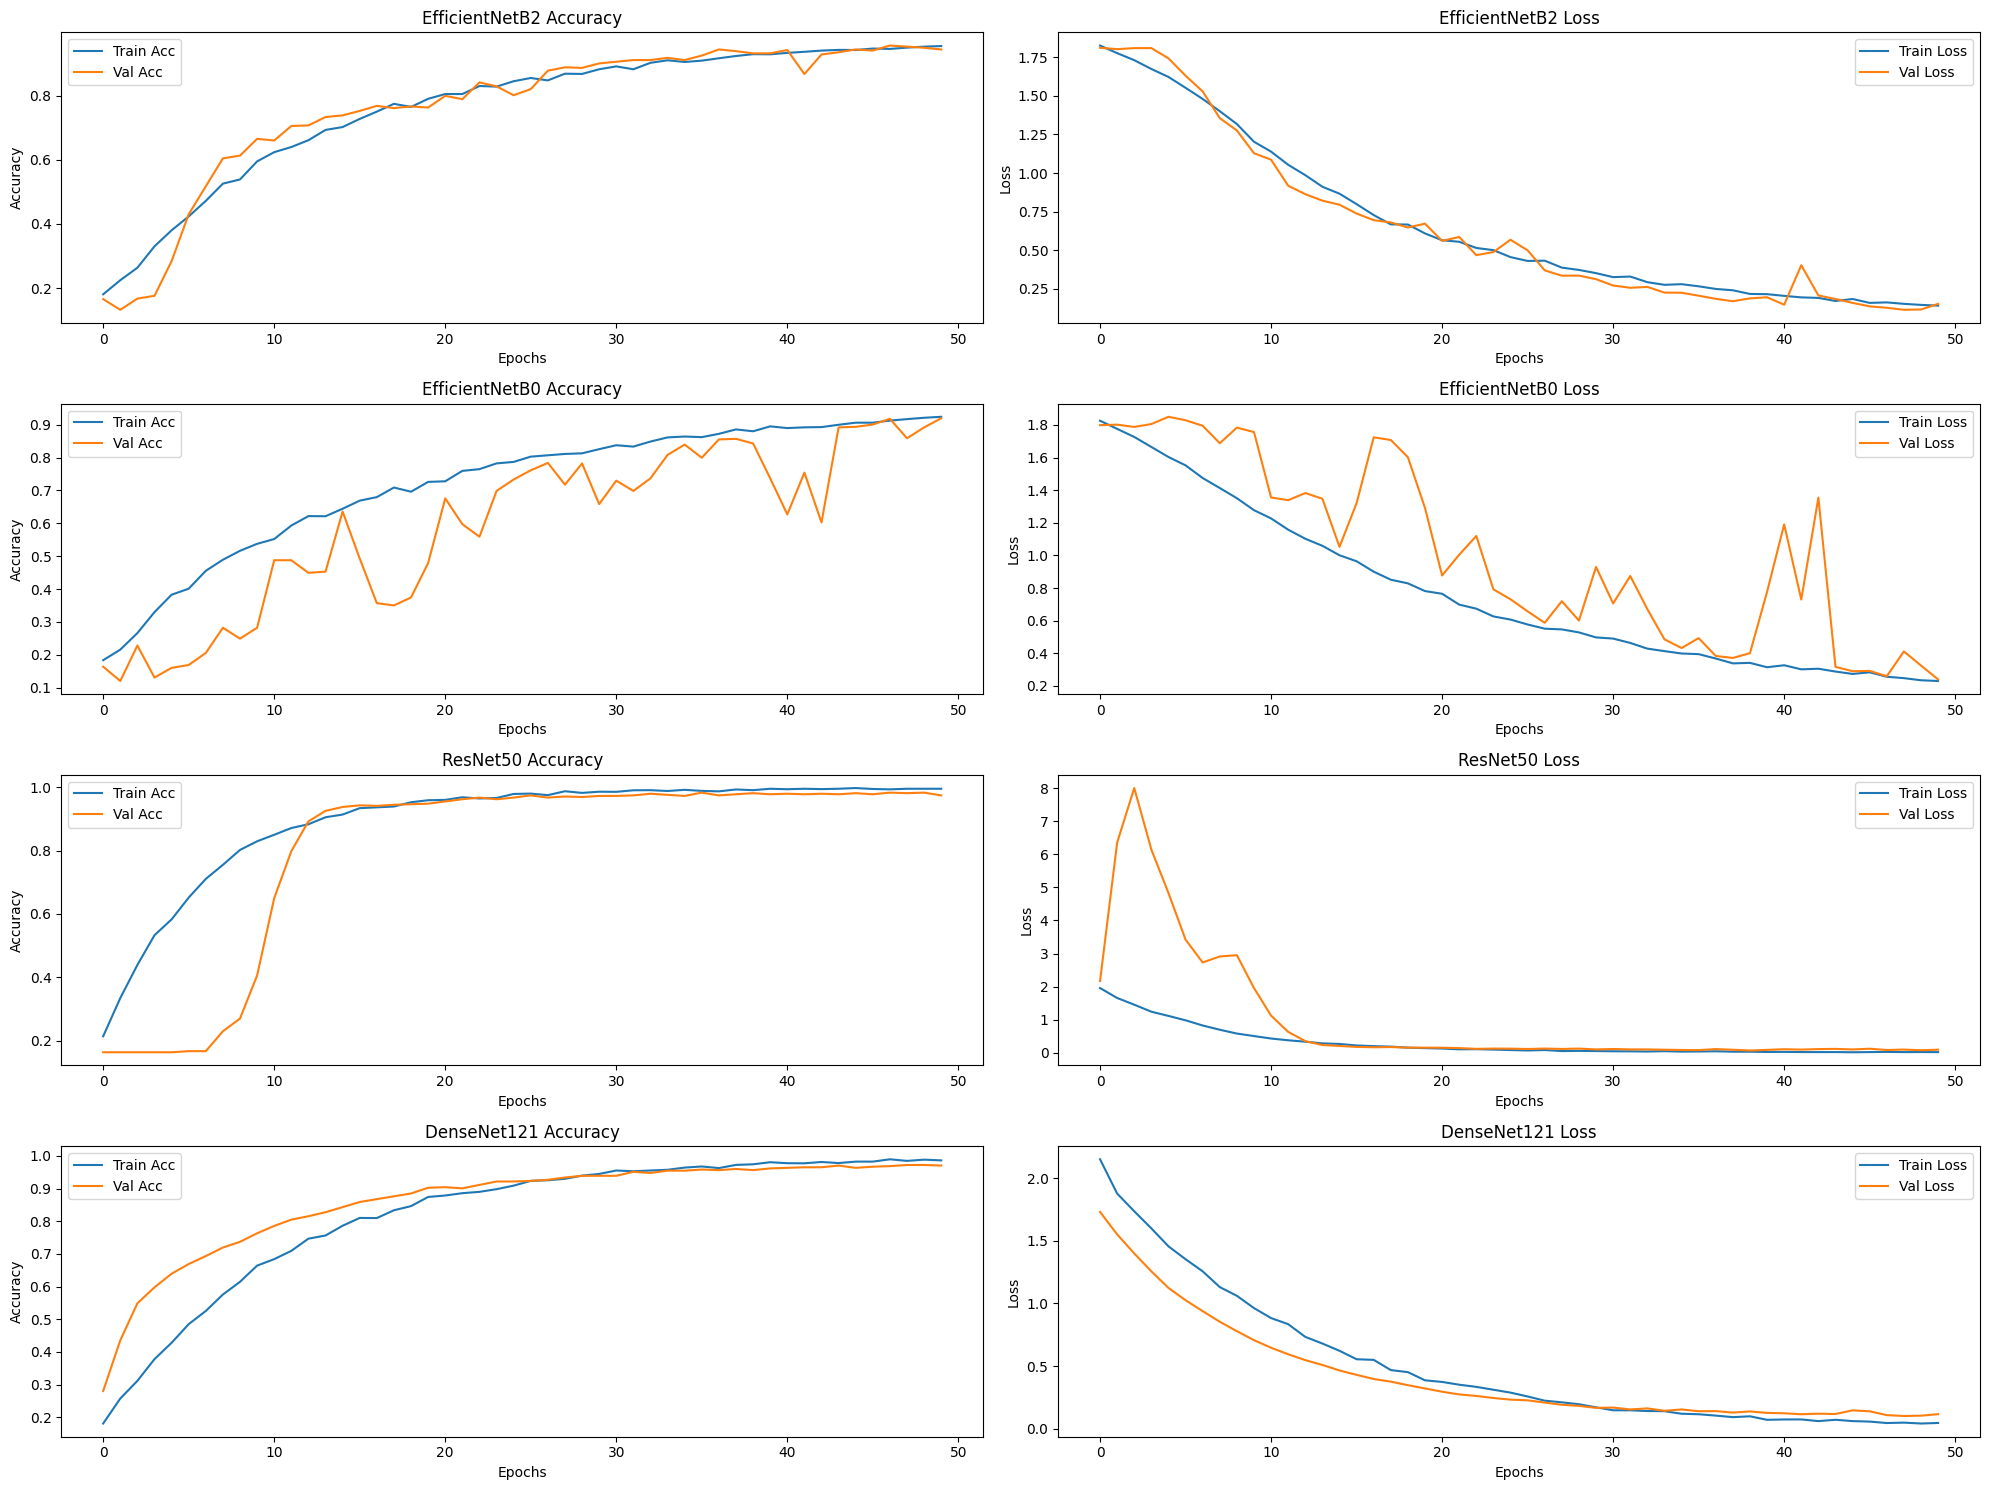

In [39]:
#accuracy and loss visualization
plt.figure(figsize=(20, 15))

for i, (model_name, result) in enumerate(results.items()):
    history = result['history']

    # Accuracy subplot
    plt.subplot(4, 2, 2 * i + 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f"{model_name} Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    # Loss subplot
    plt.subplot(4, 2, 2 * i + 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f"{model_name} Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

plt.tight_layout()
plt.show()


575/575 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step
575/575 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step
575/575 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step
575/575 ━━━━━━━━━━━━━━━━━━━━ 7s 12ms/step


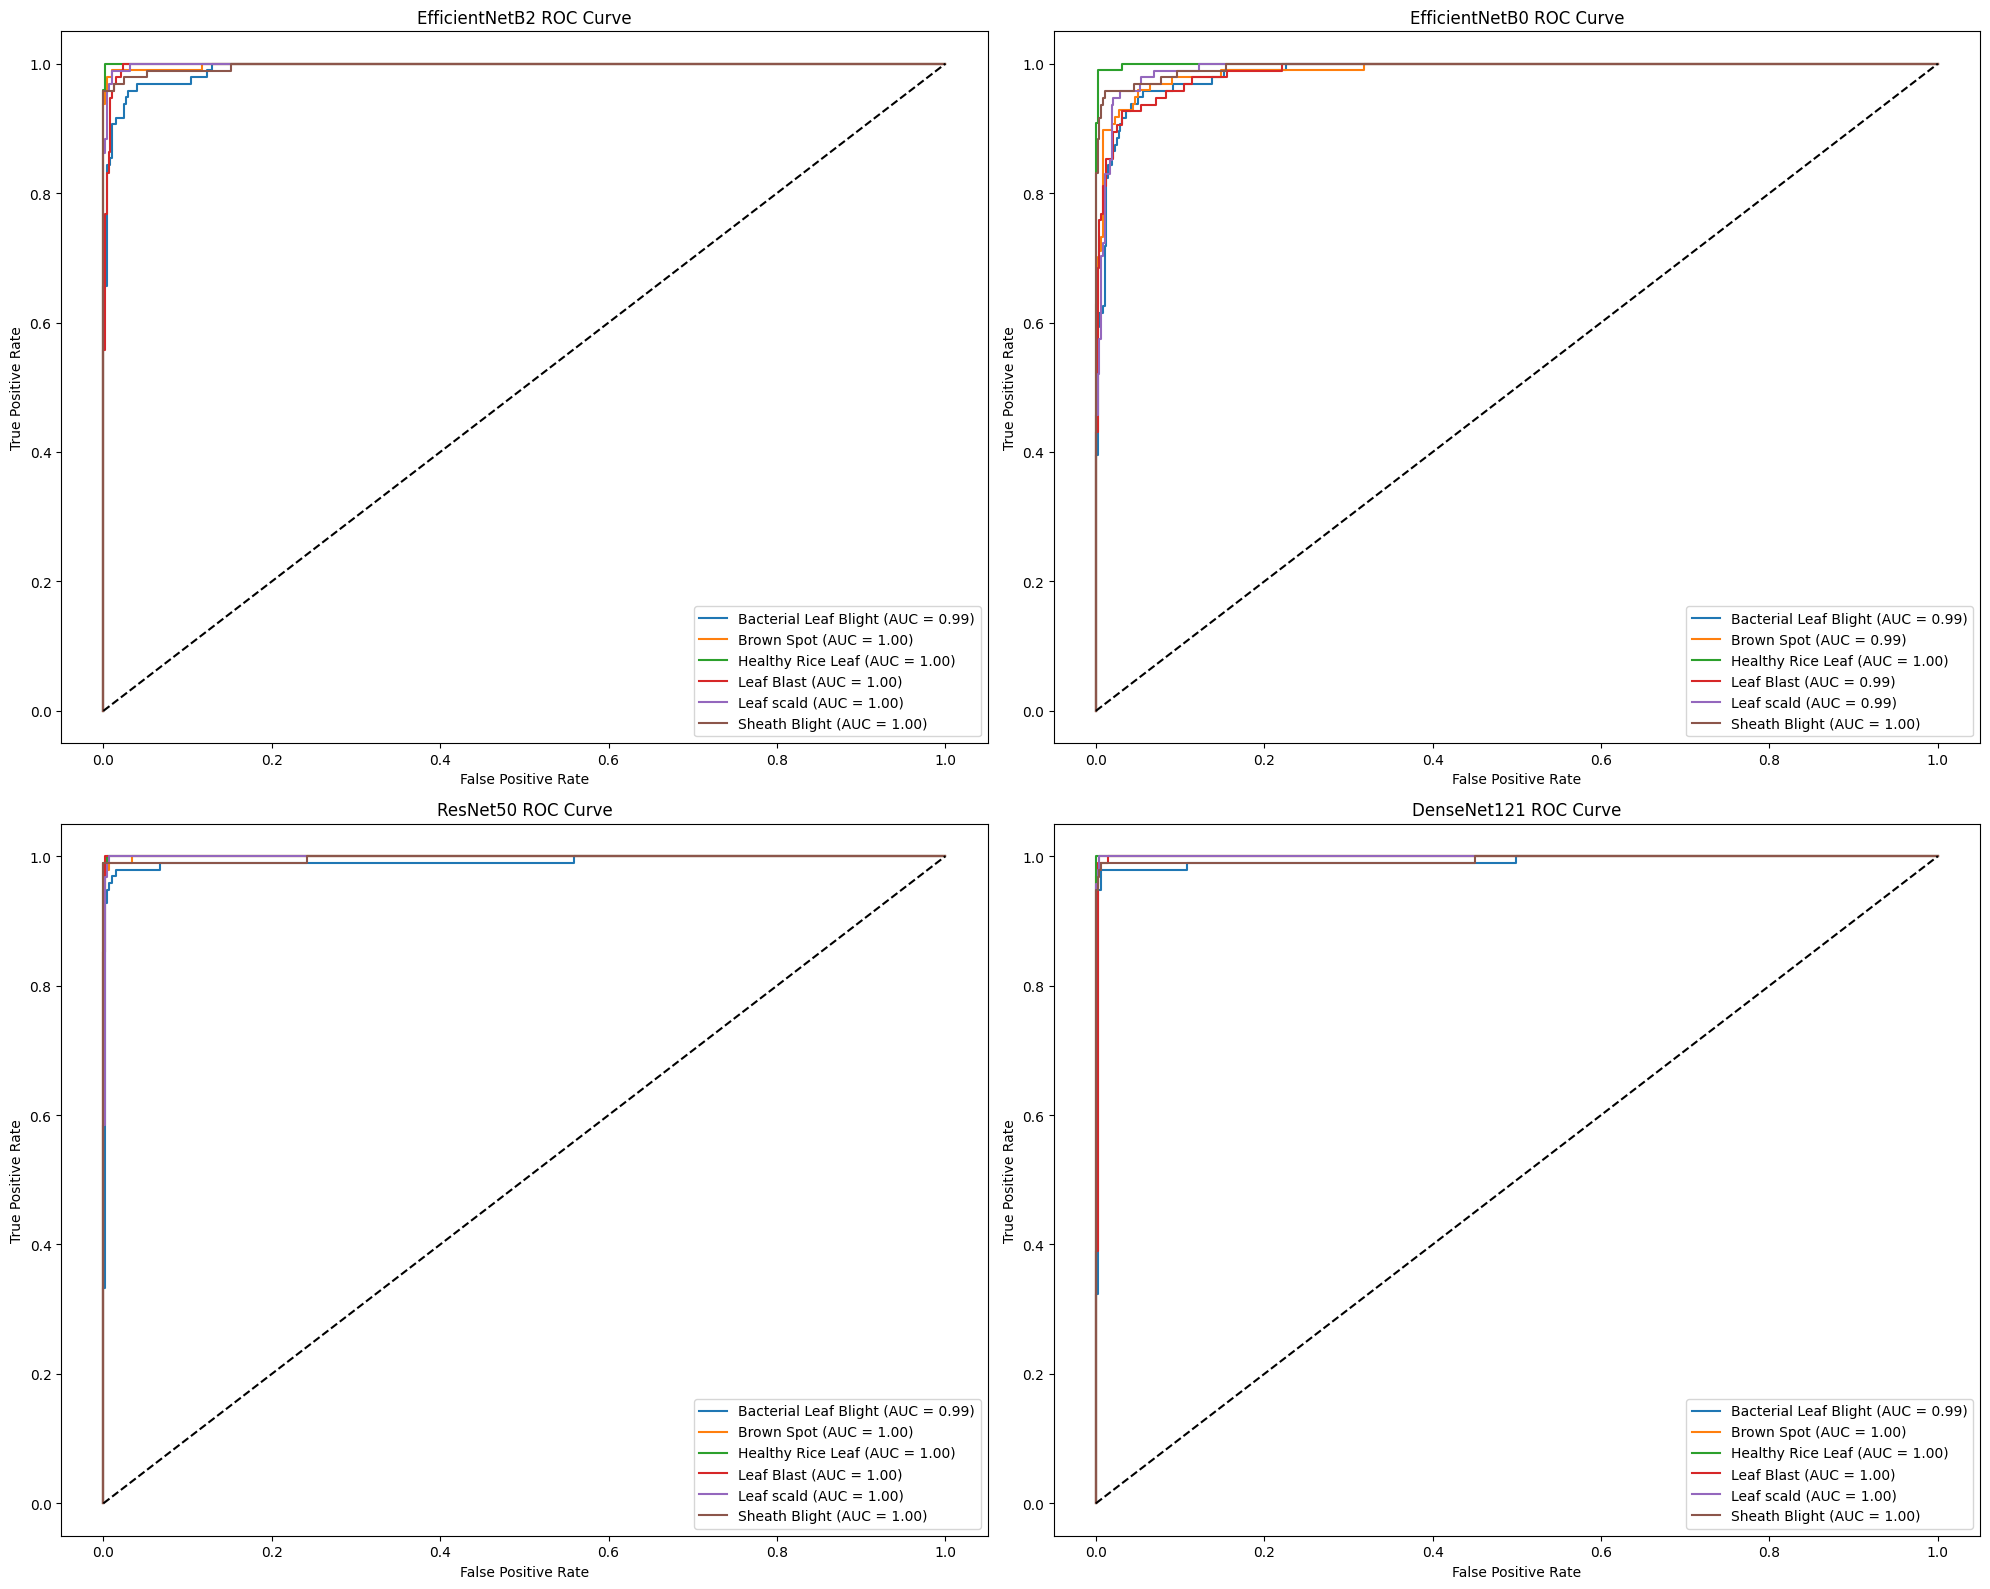

In [40]:
# Plotting ROC curves
plt.figure(figsize=(20, 16))

for idx, (model_name, result) in enumerate(results.items()):
    y_true = test_generator.classes
    y_pred_probs = result['history'].model.predict(test_generator)
    
    fpr = {}
    tpr = {}
    roc_auc = {}
    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(to_categorical(y_true, num_classes=len(class_labels))[:, i], y_pred_probs[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.subplot(2, 2, idx + 1)
    for i in range(len(class_labels)):
        plt.plot(fpr[i], tpr[i], label=f"{class_labels[i]} (AUC = {roc_auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{model_name} ROC Curve")
    plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


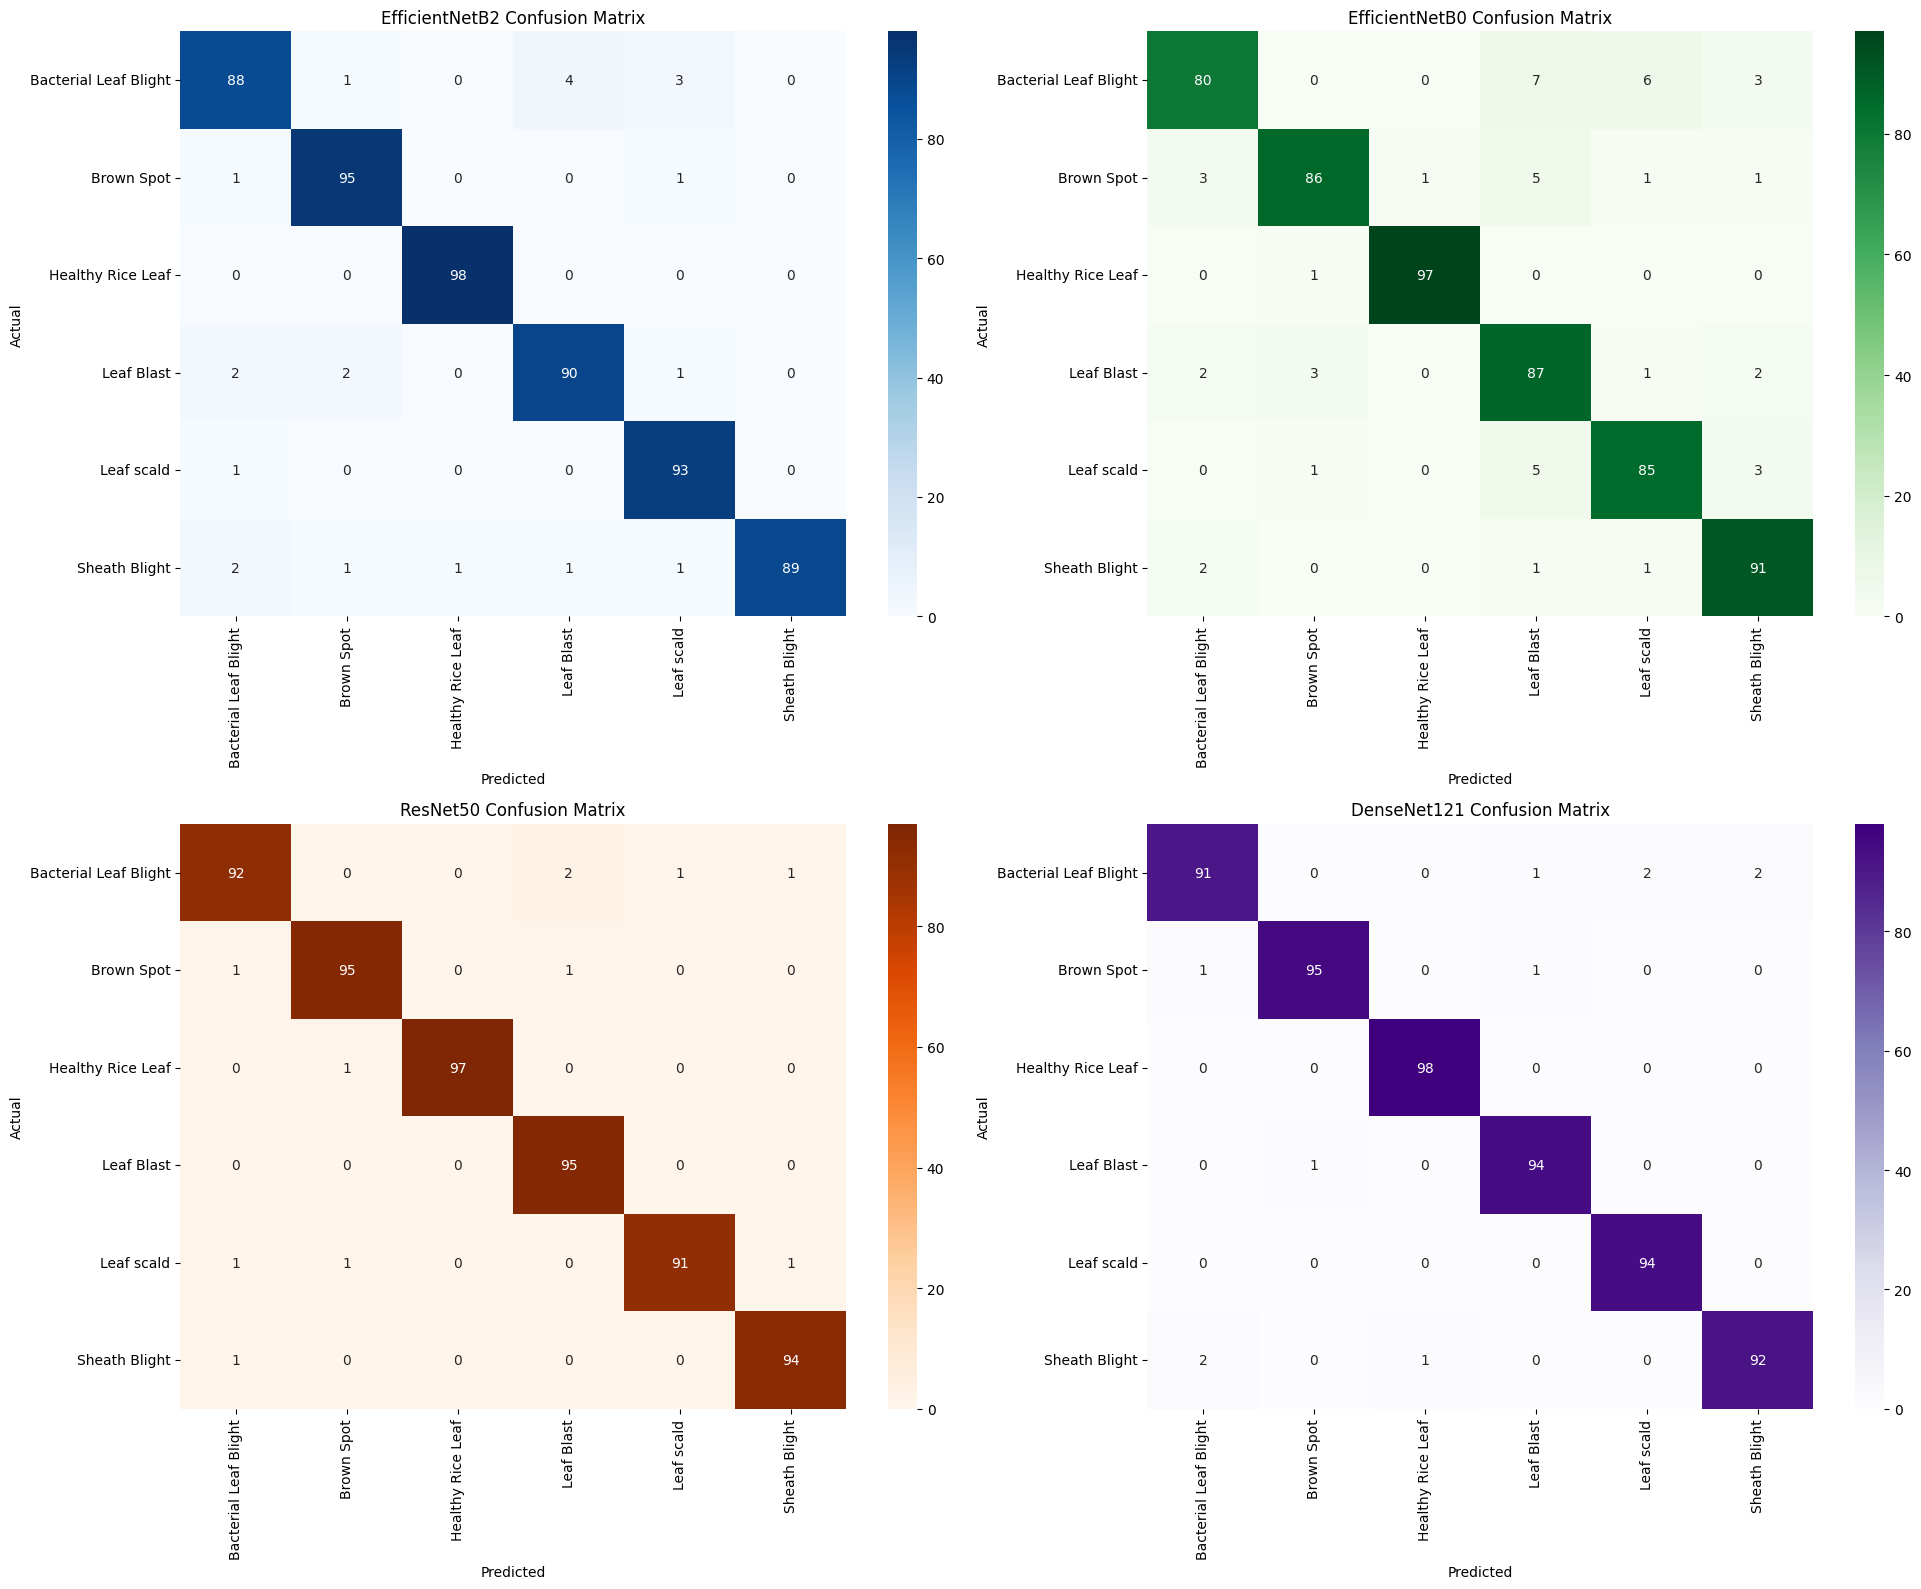

In [42]:
#confusion matrix
colormaps = ['Blues', 'Greens', 'Oranges', 'Purples']

plt.figure(figsize=(20, 16))

for idx, (model_name, result) in enumerate(results.items()):
    cm = result['conf_matrix']
    
    plt.subplot(2, 2, idx + 1)
    sns.heatmap(
        cm, annot=True, fmt='d',
        cmap=colormaps[idx],
        xticklabels=class_labels,
        yticklabels=class_labels
    )
    plt.title(f"{model_name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()


In [34]:
#summary
summary = pd.DataFrame({
    model: {
        'Test Accuracy': f"{results[model]['test_acc']:.4f}",
        'AUC Score': f"{results[model]['auc_score']:.4f}"
    } for model in results
}).T

print("\nModel Comparison Summary:")
print(summary)


Model Comparison Summary:
               Test Accuracy AUC Score
EfficientNetB2        0.9617    0.9976
EfficientNetB0        0.9148    0.9919
ResNet50              0.9809    0.9979
DenseNet121           0.9809    0.9976
